In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_addons as tfa
import numpy as np
from sklearn.utils import shuffle

import sys 
sys.path.append('../src/utils/')
sys.path.append('../src/models/')
sys.path.append('../src/visualization/')

from particles import Photon
from center_finder import CenterFinder, masked_loss, masked_loss_seed

%load_ext autoreload
%autoreload 2

/Users/polinasimkina/miniconda3/envs/envdeep/lib/python3.9/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Load and prepare data for training from one- and two-particle samples

In [2]:
photon_1 = Photon(n_pcl=1)
photon_2 = Photon(n_pcl=2)

photons = [photon_1, photon_2]

In [3]:
# define the desired model of the seed finder for data pre-processing
seed_paths = {"model_path": "../notebooks/models/seed_finder/run_3/", 
              "weight_path": "../notebooks/models/seed_finder/run_3/weights.27-0.0105.hdf5"}

In [4]:
# combine elements for 1 and 2 photon samples into one dataset
Xtrain, ytrain = ([], [], []), {'center':[], 'energy': [], 'seed': []} 
Xvalid, yvalid = ([], [], []), {'center':[], 'energy': [], 'seed': []} 

for photon in photons:
    Xi, yi = photon.data_for_center_finder("test", 0.3, **seed_paths)
    [Xtrain[i].extend(Xi[i]) for i in range(3)]
    {ytrain[i].extend(yi[i]) for i in ['center', 'energy', 'seed']}

    Xi, yi = photon.data_for_center_finder("debug", 0.3, **seed_paths)
    [Xvalid[i].extend(Xi[i]) for i in range(3)]
    {yvalid[i].extend(yi[i]) for i in ['center', 'energy', 'seed']}

Xtrain = [np.array(Xtrain[i]) for i in range(3)]
ytrain = {i: np.array(ytrain[i]) for i in ['center', 'energy', 'seed']}

Xvalid = [np.array(Xvalid[i]) for i in range(3)]
yvalid = {i: np.array(yvalid[i]) for i in ['center', 'energy', 'seed']}

100%|██████████| 100000/100000 [00:18<00:00, 5277.32it/s]
2024-01-14 18:06:10.777873: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-14 18:06:10.778169: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-14 18:06:10.778180: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-14 18:06:10.778257: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-14 18:06:10.778701: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


    46/109301 [..............................] - ETA: 4:08 

2024-01-14 18:06:12.439977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


109301/109301 [==============================] - 484s 4ms/step


100%|██████████| 1000/1000 [00:00<00:00, 5185.91it/s]


1094/1094 [==============================] - 4s 4ms/step


100%|██████████| 50000/50000 [00:12<00:00, 3923.06it/s]


52277/52277 [==============================] - 240s 5ms/step


100%|██████████| 1000/1000 [00:00<00:00, 3945.53it/s]


1040/1040 [==============================] - 4s 4ms/step


100%|██████████| 950/950 [00:00<00:00, 40918.36it/s]


In [5]:
# shuffle the samples randomly
Xtrain[0], Xtrain[1], Xtrain[2], ytrain["center"], ytrain["energy"], ytrain["seed"] = shuffle(Xtrain[0], Xtrain[1], 
                                                                                              Xtrain[2], ytrain["center"], 
                                                                                              ytrain["energy"], ytrain["seed"], 
                                                                                              random_state=42)
Xvalid[0], Xvalid[1], Xvalid[2], yvalid["center"], yvalid["energy"], yvalid["seed"] = shuffle(Xvalid[0], Xvalid[1], 
                                                                                              Xvalid[2], yvalid["center"], 
                                                                                              yvalid["energy"], yvalid["seed"], 
                                                                                              random_state=42)

# Prepare the model and training

In [6]:
# define parameters of the model
args = {
    'n' : 4,
    'conv_filter' : [32, 64], 
    'conv_kernel' : [3, 3],
    'dense_layers' : [1000, 500, 200, 200],
    'dropout' : [0.1, 0.1, 0.3, 0.1],
    'en_max' : 100,
}

In [7]:
model = CenterFinder(args)
opt = tfa.optimizers.LAMB(learning_rate=0.0001)

loss = {'energy':masked_loss, 'center':masked_loss,
                       'seed': masked_loss_seed}

loss_weights = {'energy':1, 'center': 1, 'seed': 0.05}
model.compile(optimizer=opt, loss=loss, loss_weights=loss_weights)

In [8]:
filepath = 'models/center_finder/run_2/'

checkpoint = ModelCheckpoint(str(filepath)+"/weights.{epoch:02d}-{val_loss:.4f}.hdf5", 
                                monitor='val_loss', verbose = 1, save_best_only = True, 
                                mode='auto', save_freq='epoch', save_format="tf", 
                                save_weights_only=True)

callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 30)

# Model training

In [9]:
history = model.fit(Xtrain, ytrain,
                    validation_data=(Xvalid, yvalid), 
                    epochs=30, batch_size=512, 
                    callbacks=[checkpoint, callback])

Epoch 1/30
288/288 [==============================] - ETA: 0s - loss: 0.3759 - center_loss: 0.2512 - energy_loss: 0.1235 - seed_loss: 0.0228
Epoch 1: val_loss improved from inf to 0.16542, saving model to models/center_finder/run_2/weights.01-0.1654.hdf5
288/288 [==============================] - 29s 88ms/step - loss: 0.3759 - center_loss: 0.2512 - energy_loss: 0.1235 - seed_loss: 0.0228 - val_loss: 0.1654 - val_center_loss: 0.1224 - val_energy_loss: 0.0426 - val_seed_loss: 0.0087
Epoch 2/30
288/288 [==============================] - ETA: 0s - loss: 0.1905 - center_loss: 0.1363 - energy_loss: 0.0539 - seed_loss: 0.0076
Epoch 2: val_loss improved from 0.16542 to 0.13250, saving model to models/center_finder/run_2/weights.02-0.1325.hdf5
288/288 [==============================] - 22s 77ms/step - loss: 0.1905 - center_loss: 0.1363 - energy_loss: 0.0539 - seed_loss: 0.0076 - val_loss: 0.1325 - val_center_loss: 0.0968 - val_energy_loss: 0.0353 - val_seed_loss: 0.0073
Epoch 3/30
288/288 [====

In [10]:
model.save(filepath)

INFO:tensorflow:Assets written to: models/center_finder/run_2/assets


INFO:tensorflow:Assets written to: models/center_finder/run_2/assets


# Draw loss function 

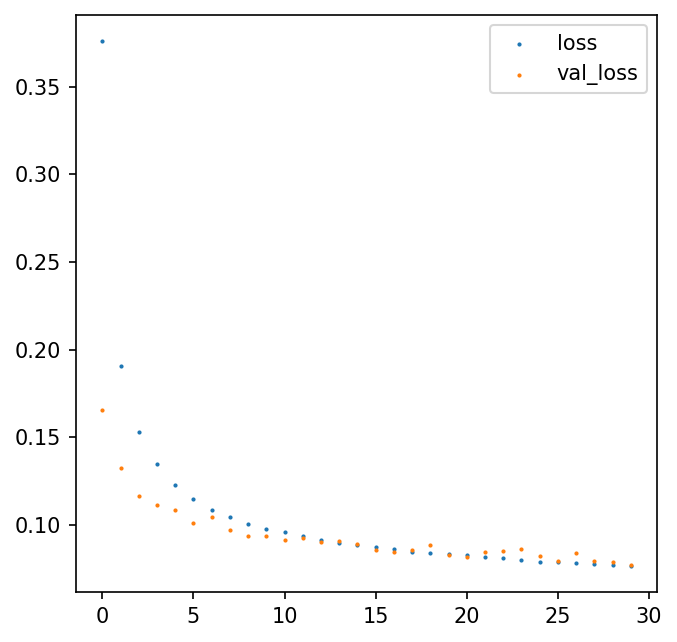

In [11]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['figure.dpi'] = 150

plt.scatter(np.arange(0,30), history.history["loss"], s=1., label='loss')
plt.scatter(np.arange(0,30), history.history["val_loss"], s=1., label='val_loss')
plt.legend()
plt.savefig(str(filepath) + '/loss_function')